### Fitting visual receptive fields
This is a brief tutorial to show the how to run receptive field fitting for SparseNoise recordings (mainly optimised for SC)
First let's load the data.

In [7]:
from pinkrigs_tools.dataset.query import load_data
from pinkrigs_tools.utils.spk_utils import format_cluster_data

exp_kwargs = {
    'subject': ['AV034'],
    'expDate': '2022-12-08',
    'expDef': ['sparseNoise'],
    'checkEvents':'1',
    'checkSpikes':'1'

    }

# determine what data to load
ephys_dict = {'spikes':'all','clusters':'all'}
# both probes
dat_kws = {'events': {'_av_trials': 'all'},'probe0':ephys_dict,'probe1':ephys_dict}

# load the recordings
recordings = load_data(data_name_dict=dat_kws,
                       merge_probes=False,
                       unwrap_probes=True, # we want to keep each probe as a separate recording of thy were recorded together
                       **exp_kwargs)

# select the first recording as an example 
rec = recordings.iloc[0]
clusters  = format_cluster_data(rec.probe.clusters)
spikes = rec.probe.spikes
ev = rec.events._av_trials

In [11]:
recordings

,alignBlock,alignEphys,alignEyeCam,alignFrontCam,alignMic,alignSideCam,alignTopCam,events,existBlock,existEphys,...,fMapFrontCam,fMapSideCam,fMapTopCam,issortedPyKS,rigName,subject,probeID,probe,ephysPath,is_curated
0,1,1,1,1,0,1,NaN,{'_av_trials': {'stimulus': [[[ True False Fal...,1,1,...,1,1,NaN,1,zelda-stim4,AV034,probe0,"{'spikes': {'amps': [0.0005524666313590765, 0....",\\zaru.cortexlab.net\Subjects\AV034\2022-12-08...,False
1,1,1,1,1,0,1,NaN,{'_av_trials': {'squareAzimuth': [-128.3333333...,1,1,...,1,1,NaN,1,zelda-stim4,AV034,probe0,"{'spikes': {'amps': [0.00020906648332547938, 0...",\\zaru.cortexlab.net\Subjects\AV034\2022-12-08...,False
2,1,1,1,1,2,1,NaN,{'_av_trials': {'squareAzimuth': [-128.3333333...,1,1,...,1,1,NaN,1,zelda-stim4,AV034,probe0,"{'spikes': {'amps': [0.00013564894656491807, 0...",\\zaru.cortexlab.net\Subjects\AV034\2022-12-08...,False
3,1,1,2,1,2,1,NaN,{'_av_trials': {'squareAzimuth': [-128.3333333...,1,1,...,1,1,NaN,1,zelda-stim4,AV034,probe0,"{'spikes': {'amps': [0.00011055774164152973, 0...",\\zaru.cortexlab.net\Subjects\AV034\2022-12-08...,False


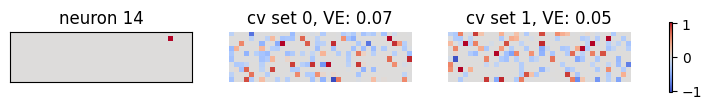

In [22]:
# we can fit the model per neuron. Let's fit and visualize the results. Takes about one minute. 
from pinkrigs_tools.utils.stats.rf_model import rf_model

m = rf_model(ev = ev,
         spikes = spikes)

m.fit_evaluate(mode = 'per-neuron') # one minute

# select neurons that have a good fit on the test set
df =  m.score.sel(cv_number=1).to_pandas()
df = df.to_frame(name='rf_VE_test')
df.reset_index(inplace=True)
df['is_significant'] = df.rf_VE_test>0.02
# plot a random sample 
IDs = df[df.is_significant].sample(1,random_state=12,replace=False).neuronID.values
m.plot_fit(ID=IDs)


<Axes: xlabel='Density', ylabel='depths'>

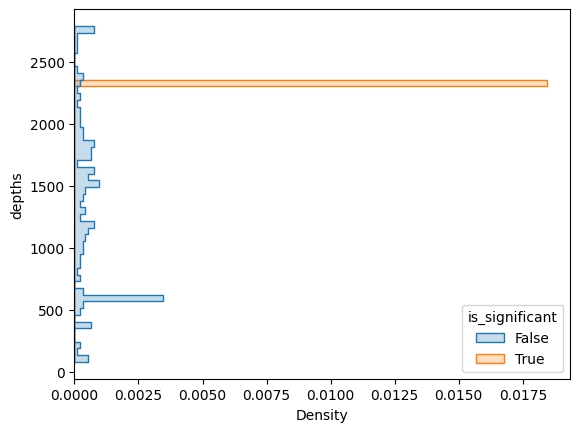

In [23]:
# we can also plot the histogram of significant neurons acorss the shank 
import seaborn as sns 

df[['rf_azimuth', 'rf_elevation', 'rf_azimuth_sigma', 'rf_elevation_sigma']] = list(zip(*m.get_rf_degs_from_fit()))

clusters['neuronID'] = clusters._av_IDs
clusters = clusters.merge(df,on='neuronID',how='left')

sns.histplot(data=clusters,y='depths',hue='is_significant',bins=50,element='step',stat='density',common_norm=False)

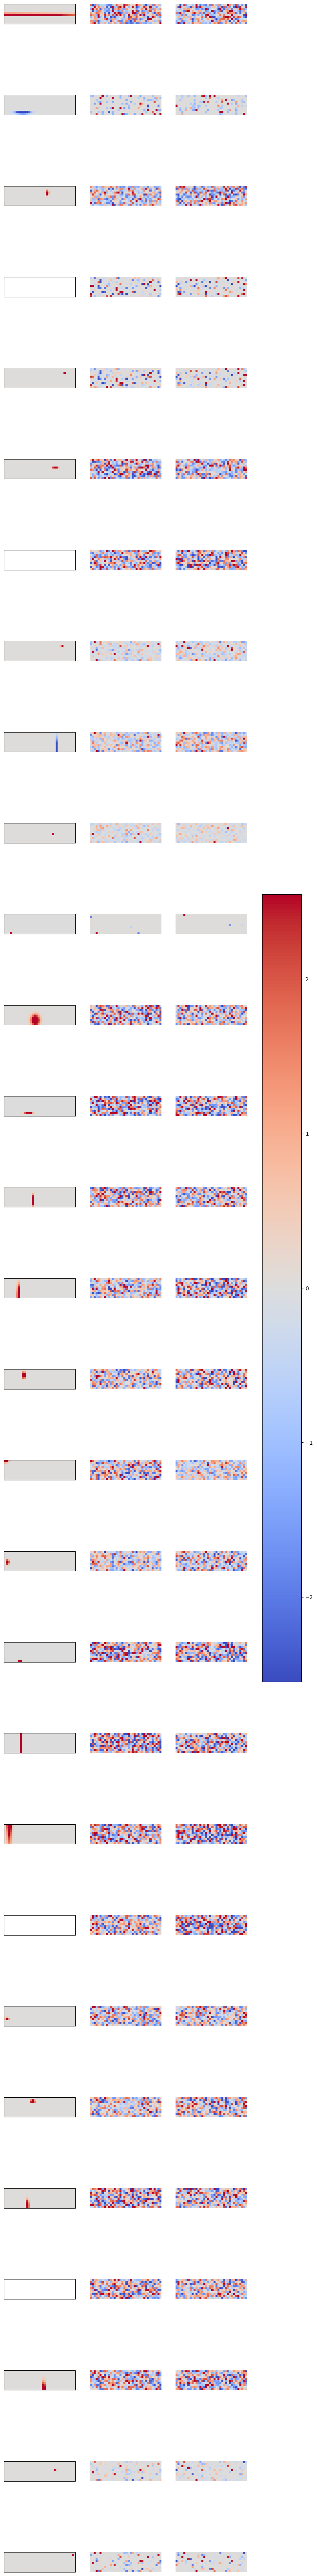

In [24]:
# can also fit in depth mode, i.e. we bin all spikes by depth and calculate a MUA response per depth bin

# now the depth mode 
m.fit_evaluate(mode = 'per-depth',depth_spacing = 100)# spacing in um
#
depths = m.predictions.neuronID.values[::-1]
m.plot_fit(ID=depths)


In [ ]:
# we can do a shuffle test but it is very computationally expensive (20 mins for 20 shuffles). 
# I have tested that in practice >0.025 VE on the test set is never reached by change so 0.05 is a safe threshold
m.get_significant_rfs() 
significants = m.is_significant